In [1]:
import pandas as pd
import numpy as np

from sklearn.cluster import SpectralClustering
from sklearn.cluster.k_means_ import k_means
from sklearn.manifold import spectral_embedding
from sklearn.manifold.spectral_embedding_ import _set_diag
from sklearn.utils.extmath import _deterministic_vector_sign_flip

from scipy.linalg import fractional_matrix_power
from scipy.sparse.csgraph import laplacian

np.set_printoptions(precision = 3)

import geopandas as gpd

import psycopg2
from fiona.crs import from_epsg

from netrc import netrc
user, acct, passwd = netrc().authenticators("harris")

import matplotlib.pyplot as plt

import requests

import seaborn as sns
sns.set(rc={"figure.figsize": (1, 1)})
sns.set_style("white")

%matplotlib inline

In [2]:
geo_tracts = gpd.read_postgis("SELECT state::bigint * 1000000000 + county * 1000000 + tract geoid, "
                              "ST_Transform(geom, 3528) geom "
                              "FROM census_tracts_2015 "
                              "WHERE state = 17 AND (county IN (31, 43, 197));",
                              con = psycopg2.connect(database = "census", user = user, password = passwd,
                                                     host = "saxon.harris.uchicago.edu", port = 5432),
                              index_col = "geoid", geom_col = "geom", crs = from_epsg(3528))

chicago = gpd.read_file("chicago.geojson").to_crs(epsg = 3528).unary_union
chi_tracts = sorted(list(geo_tracts[geo_tracts.centroid.within(chicago)].index))

traces = pd.read_csv("c_adjacencies.csv", names = ["h", "o", "a"])

In [3]:
mtraces = traces.pivot(index = "h", columns = "o", values = "a").fillna(0).sort_index()
mtraces = mtraces.loc[chi_tracts].dropna()
mtraces = mtraces[list(mtraces.index)]
mtraces = mtraces.div(mtraces.sum(axis=1), axis=0)
np_mtraces = mtraces.as_matrix()
# np_mtraces

In [30]:
A = np_mtraces.copy()
A = A + A.T
np.fill_diagonal(A, 0)
D = np.diag(A.sum(axis = 0))

L = D - A
Lnorm = np.dot(np.dot(fractional_matrix_power(D, -1/2), L), fractional_matrix_power(D, 1/2))
Lrw   = np.dot(fractional_matrix_power(D, -1), L)


Lscipy = laplacian(A, normed=False, return_diag = False)
Lscipy_normed = laplacian(A, normed=True, return_diag = False)
Lsklearn = _set_diag(Lscipy, 1, False)

Lvariants = {"Lnorm" : Lnorm, "Lsklearn" : Lsklearn, "Lscipy" : Lscipy, 
             "Lscipy_normed" : Lscipy_normed, "L" : L, "Lrw" : Lrw}

We find that 
* L = Lscipy = Lsklearn ≈ Lnorm (good!!), 
* Lrw ≈ L_scipy_normed.  (So the scipy norming is random walk -- this is what sklearn does).
So I'll focus on Lnorm and Lrw.

In [34]:
# for n, M in Lvariants.items():
# for n, M in {"Lnorm" : Lnorm, "Lrw" : Lrw}.items():
for n, M in {"Lrw" : Lrw}.items():

    vals, vecs = np.linalg.eig(M)

    idx = vals.argsort()[1:]
    vals = vals[idx]
    vecs = vecs[:,idx].T
    vecs = _deterministic_vector_sign_flip(vecs)

    spectrum = pd.DataFrame({"v{:02d}".format(x) : pd.Series(index = mtraces.index, data = list(vecs[x])) 
                             for x in range(20)})

    spectral_map = geo_tracts.join(spectrum).dropna()

    print("{: >13} :: ".format(n), end = "")
    for x in range(20):

        print(x, end = " ")
        ax = map_format(spectral_map.plot(column = "v{:02d}".format(x), 
                                          cmap = "nipy_spectral", k = 100))
        ax.figure.savefig("figs/spectrum{:02d}_{}.pdf".format(x, n))

        plt.close('all')
        
    print(end = " // ")

    for ncl in list(range(2,11)) + [15, 20, 25, 30, 50]:
        
        _, labels, _ = k_means(vecs[:ncl].T, ncl, random_state = 1, n_init = 500)

        clustered = geo_tracts.join(pd.Series(name = "Clusters", index = mtraces.index, data = labels)).dropna()

        ax = map_format(clustered.dissolve("Clusters").plot(cmap = "nipy_spectral", 
                                                            edgecolor = "black", linewidth = 0.25))

        ax.figure.savefig("figs/{}_clusters{:02d}.pdf".format(n, ncl))
        plt.close('all')
        
        print(ncl, end = " ")


    plt.close('all')
    print()

        Lnorm :: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19  // 2 3 4 5 6 7 8 9 10 15 20 25 30 50 
          Lrw :: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19  // 2 3 4 5 6 7 8 9 10 15 20 25 30 50 


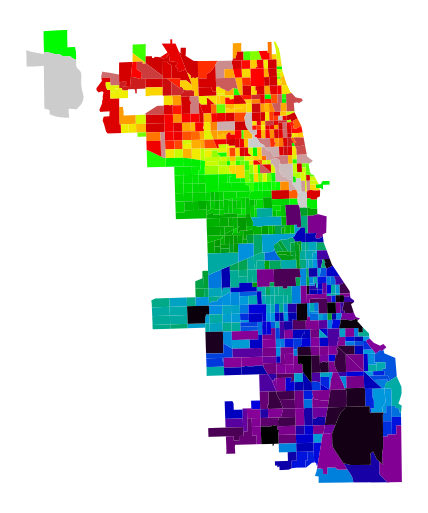

In [40]:
mtraces = traces.pivot(index = "h", columns = "o", values = "a").fillna(0).sort_index()
mtraces = mtraces.loc[chi_tracts].dropna()
mtraces = mtraces[list(mtraces.index)]
mtraces = mtraces.div(mtraces.sum(axis=1), axis=0)
np_mtraces = mtraces.as_matrix()
A = np_mtraces + np_mtraces.T

eigen = spectral_embedding(A, n_components = 20, norm_laplacian = True, drop_first = True)
spectral_map = geo_tracts.join(pd.Series(index = mtraces.index, data = eigen[:,0], name = "Spectrum")).dropna()

map_format(spectral_map.plot(categorical = True, column = "Spectrum", 
                             figsize = (12, 4), cmap = "nipy_spectral"))

/home/jsaxon/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:640: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  warnings.warn("Array is not symmetric, and will be converted "


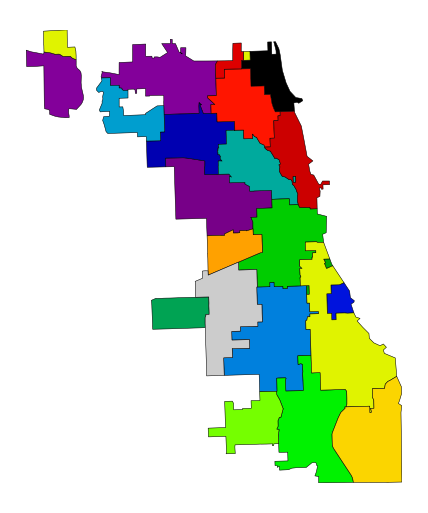

In [41]:
spectral = SpectralClustering(n_clusters = 20, affinity = "precomputed", random_state = 1, n_init = 500)

mtraces = traces.pivot(index = "h", columns = "o", values = "a").fillna(0).sort_index()
mtraces = mtraces.loc[chi_tracts].dropna()
mtraces = mtraces[list(mtraces.index)]
mtraces = mtraces.div(mtraces.sum(axis=1), axis=0)
np_mtraces = mtraces.as_matrix()

spectral_map = geo_tracts.join(pd.Series(index = mtraces.index, 
                                         data = spectral.fit_predict(np_mtraces), 
                                         name = "Spectrum")).dropna()

ax = map_format(spectral_map.dissolve("Spectrum").plot(figsize = (12, 4),
                                                       cmap = "nipy_spectral", 
                                                       edgecolor = "black", linewidth = 0.25))

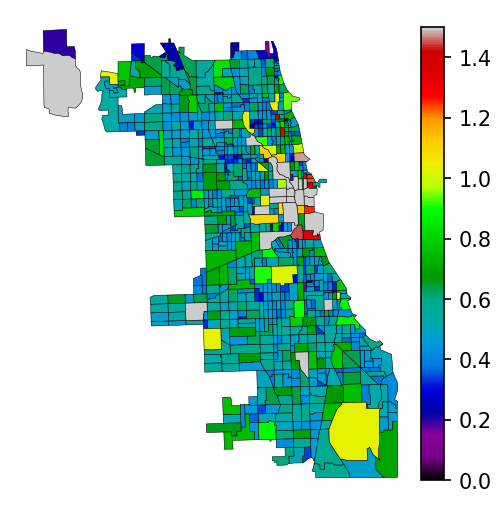

In [44]:
K = np.dot(np.sum(np.linalg.matrix_power(np_mtraces.T / 2.7, p) for p in range(1, 21)), np.ones(np_mtraces.shape[0]))

spectral_map = geo_tracts.join(pd.Series(index = mtraces.index, 
                                         data = K, 
                                         name = "Influence")).dropna()

ax = map_format(spectral_map.plot(column = "Influence", figsize = (4, 4),
                                  cmap = "nipy_spectral", # scheme = "quantiles", 
                                  k = 20, legend = True, vmin = 0, vmax = 1.5,
                                  edgecolor = "black", linewidth = 0.25))

# ax.get_legend().set_bbox_to_anchor((1.3, 0.97))
ax.figure.savefig("figs/influence.pdf")

## Now load Illinois LODES data for comparison.

(0, 1.5)

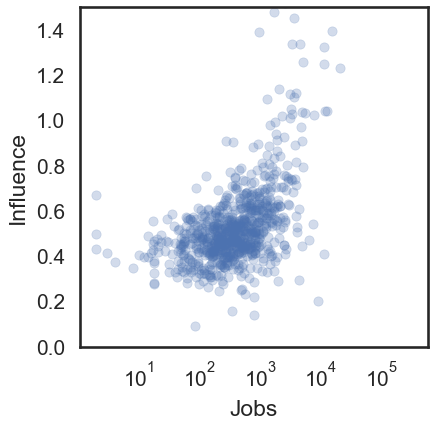

In [116]:
jobs = pd.read_csv("../lodes/tract/il_od_JT00_2015.csv.gz", compression = "gzip")
jobs = jobs.rename(columns = {"w_state" : "state" , "w_county" : "county", "w_tract" : "tract"})
jobs["geoid"] = jobs["state"] * 1000000000 + jobs["county"] * 1000000 + jobs["tract"] 
jobs = jobs[jobs.county == 31].groupby("geoid").sum()
jobs = jobs[["SE01", "SE02", "SE03"]]
jobs["Jobs"] = jobs.sum(axis = 1)

chi_infl = jobs.join(pd.Series(index = mtraces.index, data = K, name = "Influence")).dropna()

ax = chi_infl.plot(kind = "scatter", x = "Jobs", y = "Influence", 
                   figsize = (3, 3), logx = True, alpha = 0.25)

ax.set_ylim(0, 1.5)

In [4]:
census_vars = {"DP02_0086E" : "TOTAL_POP", "DP05_0060PE" : "PCT_BLACK", "DP05_0066PE" : "PCT_HISP",
               "DP02_0066PE" : "HS_PCT", "DP02_0067PE" : "BA_PCT", "DP02_0065PE" : "ADV_PCT",
               "DP03_0062E" : "MHI", "DP03_0119PE" : "POV_PCT", "DP03_0009PE" : "PCT_UNEMP"}

census_vals = list(census_vars.values())

census_labels = {"HS_PCT" : "HS Graduate [%]", "BA_PCT" : "Bachelor's Degree [%]", "ADV_PCT" : "Advanced Degree [%]",
                 "MHI" : "Median Household Income [k$]", "POV_PCT" : "Under the Poverty Line [%]",
                 "PCT_BLACK" : "Black [%]", "PCT_HISP" : "Hispanic [%]",
                 "PCT_UNEMP" : "Unemployment Rate [%]"}

url = "https://api.census.gov/data/2014/acs5/profile?for=tract:*&in=state:17+county:31&get=NAME,"
url = url + ",".join(census_vars.keys())

j = requests.get(url).json()
census = pd.DataFrame(j[1:], columns = j[0])
census.rename(columns = census_vars, inplace = True)

for v in list(census_vars.values()) + ["state", "county", "tract"]:
    census[v] = pd.to_numeric(census[v], errors = "coerce")
    
census["MHI"] /= 1e3

census["GEOID"] = census["state"] * 1000000000 + census["county"] * 1000000 + census["tract"]
census.set_index("GEOID", inplace = True)
census.index.name = "GEOID"

census.to_csv("ana_data/chicago_base_vars.csv")

In [86]:
census = census.join(pd.Series(index = mtraces.index, data = K, name = "Influence")).dropna()

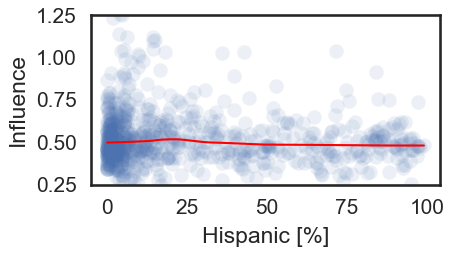

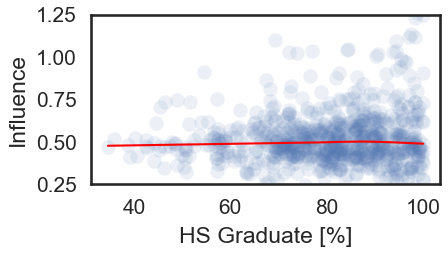

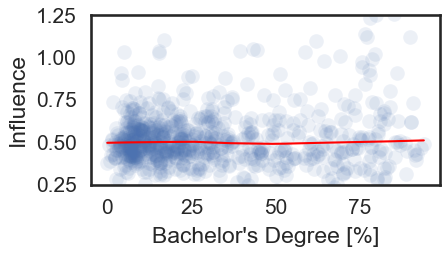

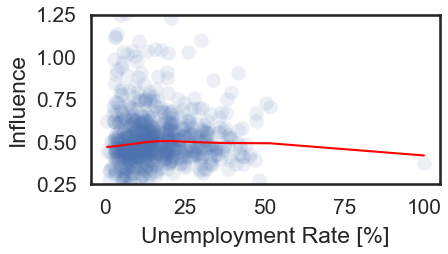

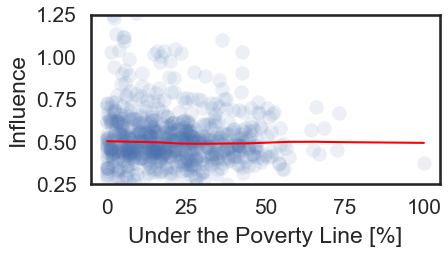

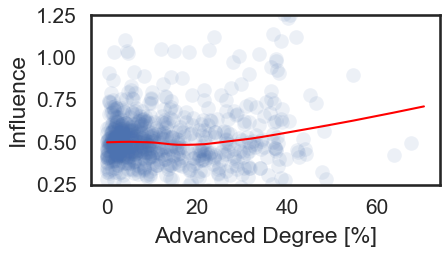

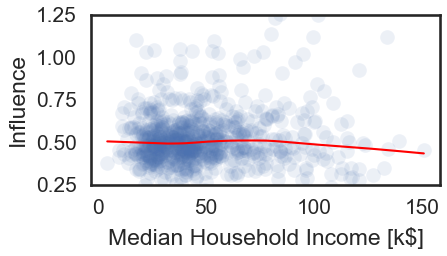

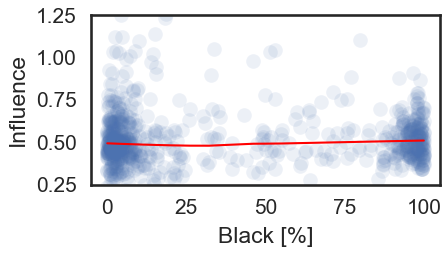

In [112]:
for k, v in census_labels.items():

    fix, ax = plt.subplots(figsize = (3, 1.5))
    sns.regplot(data = census, x = k, y = "Influence", lowess = True, 
                scatter_kws = {"alpha" : 0.1}, line_kws = {"color" : "red", "linewidth" : 1}, ax = ax)

    ax.set_ylim(0.25, 1.25)
    ax.set_xlabel(v)
